# Comprehensive Model Comparison: Network Payload Classification

## Executive Summary

This notebook provides a comprehensive analysis of different deep learning architectures for network payload classification, comparing Vision Transformers (ViT), ResNet-18, CNNs, LSTMs, and 1D CNNs across different data representations.

## Key Findings

### 🏆 Performance Rankings

1. **CNN1D-Residual (Raw Bytes)**: 94.87% - Best overall performance
2. **ViT (RGB Hilbert)**: 93.81% - Strong attention-based performance  
3. **ResNet-18 (RGB Hilbert)**: 93.81% - Matches ViT exactly
4. **CNN (RGB Hilbert)**: 93.73% - Close to ViT/ResNet
5. **LSTM (RGB Hilbert)**: 90.59% - Sequential processing trails behind
6. **CNN1D-Standard (Raw Bytes)**: 80.48% - Baseline without residuals

### 📊 Key Insights

- **Raw bytes outperform Hilbert encoding** when using appropriate architecture (1D CNN with residuals)
- **Residual connections are crucial** - improving 1D CNN from 80.48% to 94.87%
- **ViT and ResNet-18 perform identically** at 93.81%, suggesting a performance ceiling for Hilbert encoding
- **LSTM underperforms** despite sequential nature of network data
- **Model efficiency varies greatly** - LSTM uses only 0.32M parameters vs 4.94M for ViT


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define model results based on our experiments
model_results = {
    'Model': ['CNN1D-Residual', 'ViT', 'ResNet-18', 'CNN', 'LSTM', 'CNN1D-Standard'],
    'Architecture Type': ['1D Convolutional', 'Transformer', 'Residual CNN', '2D Convolutional', 'Recurrent', '1D Convolutional'],
    'Data Representation': ['Raw Bytes', 'RGB Hilbert', 'RGB Hilbert', 'RGB Hilbert', 'RGB Hilbert', 'Raw Bytes'],
    'Test Accuracy': [0.9487, 0.9381, 0.9381, 0.9373, 0.9059, 0.8048],
    'Parameters (M)': [1.69, 4.94, 11.18, 4.82, 0.32, 1.55],
    'Input Size': [1024, 3072, 3072, 3072, 3072, 1024],
    'Few-Shot ARI': [np.nan, 0.466, np.nan, np.nan, np.nan, np.nan],
    'Few-Shot Silhouette': [np.nan, 0.276, np.nan, np.nan, np.nan, np.nan]
}

df_results = pd.DataFrame(model_results)

# Calculate efficiency metrics
df_results['Accuracy per Million Params'] = df_results['Test Accuracy'] / df_results['Parameters (M)']
df_results['Accuracy Rank'] = df_results['Test Accuracy'].rank(ascending=False, method='min')

print("📊 Model Performance Summary")
print("="*80)
print(df_results[['Model', 'Test Accuracy', 'Parameters (M)', 'Data Representation']].to_string(index=False))
print("\n✓ Data loaded and metrics calculated")


📊 Model Performance Summary
         Model  Test Accuracy  Parameters (M) Data Representation
CNN1D-Residual         0.9487            1.69           Raw Bytes
           ViT         0.9381            4.94         RGB Hilbert
     ResNet-18         0.9381           11.18         RGB Hilbert
           CNN         0.9373            4.82         RGB Hilbert
          LSTM         0.9059            0.32         RGB Hilbert
CNN1D-Standard         0.8048            1.55           Raw Bytes

✓ Data loaded and metrics calculated


## Section 1: Overall Performance Comparison

First, let's visualize the test accuracy across all models to understand the performance landscape.


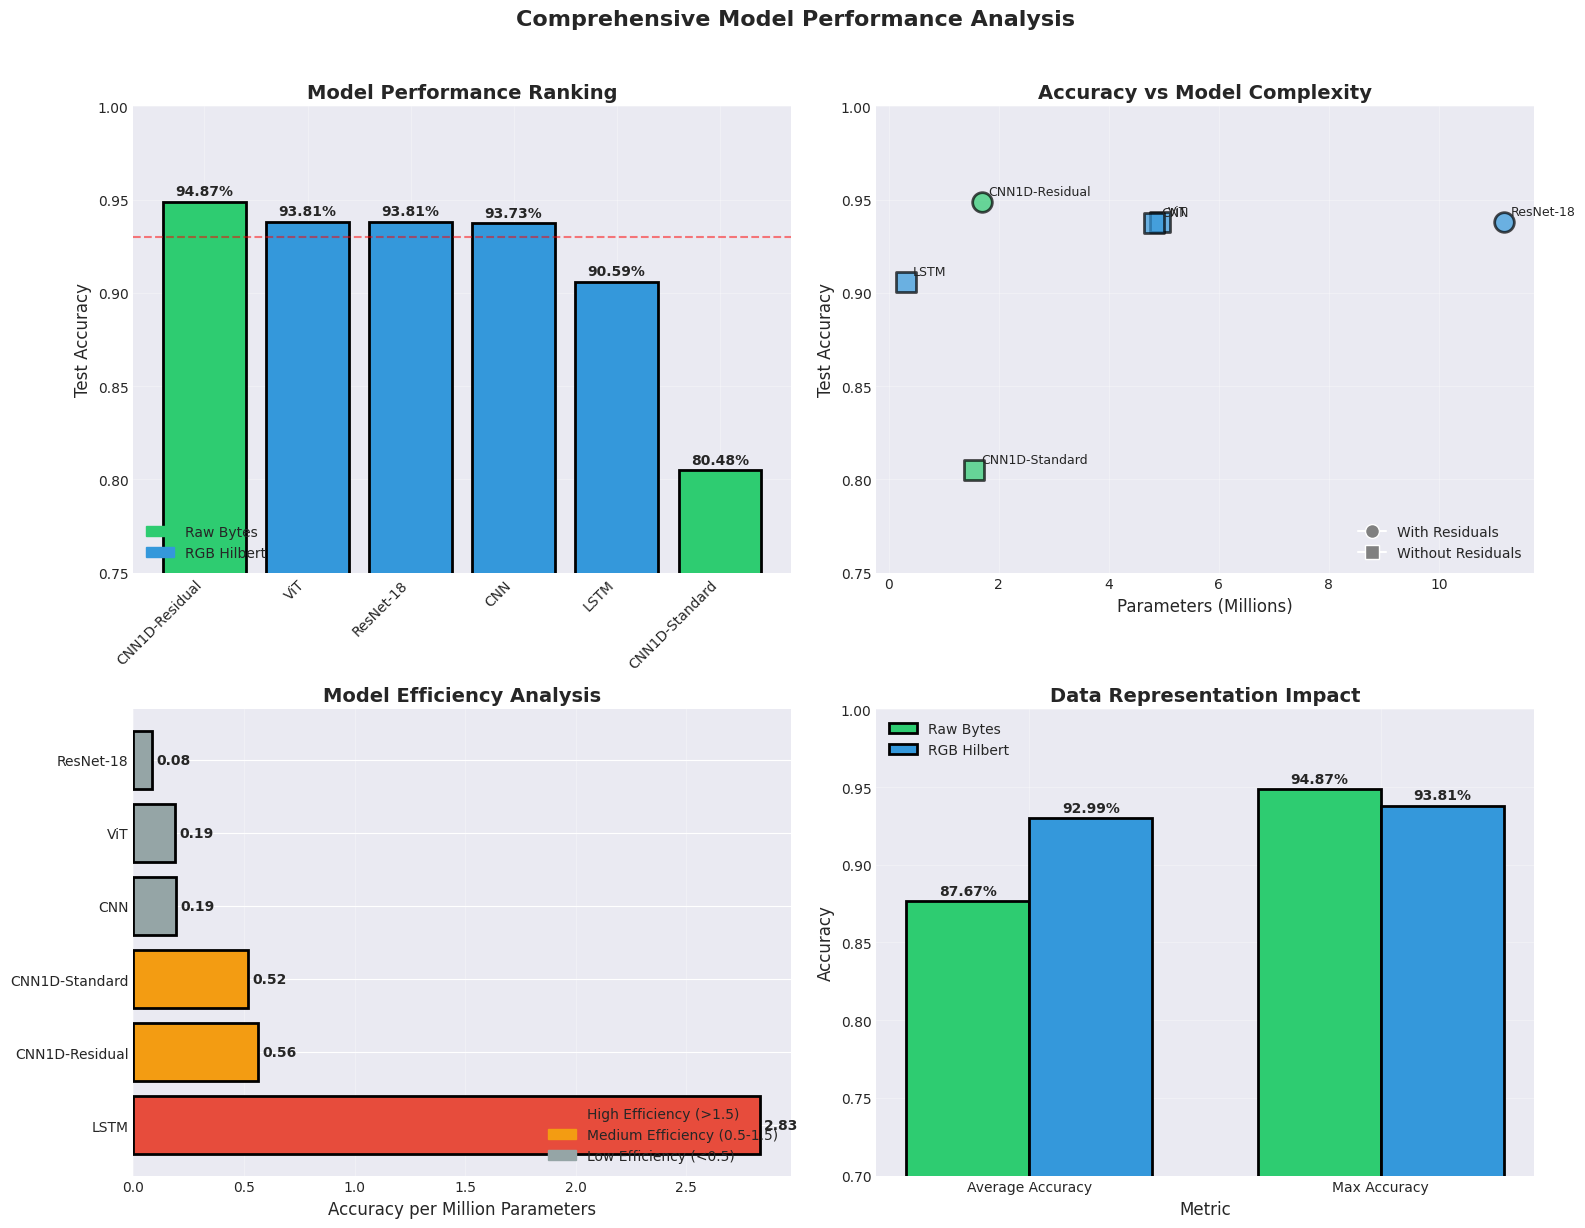

📊 Key Observations:
• Best overall accuracy: CNN1D-Residual with 94.87%
• Most efficient model: LSTM with 2.83 accuracy/M params
• Raw bytes average: 87.67%, RGB Hilbert average: 92.99%
• Residual connections boost CNN1D from 80.48% to 94.87%


In [2]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by accuracy for better visualization
df_sorted = df_results.sort_values('Test Accuracy', ascending=False)

# 1. Bar chart of test accuracies
ax1 = axes[0, 0]
colors = ['#2ecc71' if 'Raw' in rep else '#3498db' for rep in df_sorted['Data Representation']]
bars = ax1.bar(range(len(df_sorted)), df_sorted['Test Accuracy'], color=colors, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, df_sorted['Test Accuracy'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{val:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_xticks(range(len(df_sorted)))
ax1.set_xticklabels(df_sorted['Model'], rotation=45, ha='right')
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Model Performance Ranking', fontsize=14, fontweight='bold')
ax1.set_ylim(0.75, 1.0)
ax1.axhline(y=0.93, color='red', linestyle='--', alpha=0.5, label='93% Threshold')
ax1.grid(True, alpha=0.3)

# Add legend for data representation
green_patch = mpatches.Patch(color='#2ecc71', label='Raw Bytes')
blue_patch = mpatches.Patch(color='#3498db', label='RGB Hilbert')
ax1.legend(handles=[green_patch, blue_patch], loc='lower left')

# 2. Accuracy vs Parameters scatter plot
ax2 = axes[0, 1]
for i, row in df_results.iterrows():
    color = '#2ecc71' if 'Raw' in row['Data Representation'] else '#3498db'
    marker = 'o' if 'Residual' in row['Model'] or 'ResNet' in row['Model'] else 's'
    ax2.scatter(row['Parameters (M)'], row['Test Accuracy'], 
                s=200, c=color, marker=marker, edgecolor='black', linewidth=2, alpha=0.7)
    ax2.annotate(row['Model'], 
                (row['Parameters (M)'], row['Test Accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Parameters (Millions)', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Model Complexity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.75, 1.0)

# Add legend for markers
circle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='With Residuals')
square = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, label='Without Residuals')
ax2.legend(handles=[circle, square], loc='lower right')

# 3. Efficiency comparison (Accuracy per Million Parameters)
ax3 = axes[1, 0]
df_efficiency = df_results.sort_values('Accuracy per Million Params', ascending=False)
colors_eff = ['#e74c3c' if acc > 1.5 else '#f39c12' if acc > 0.5 else '#95a5a6' 
              for acc in df_efficiency['Accuracy per Million Params']]
bars_eff = ax3.barh(range(len(df_efficiency)), df_efficiency['Accuracy per Million Params'], 
                     color=colors_eff, edgecolor='black', linewidth=2)

# Add value labels
for i, (bar, val) in enumerate(zip(bars_eff, df_efficiency['Accuracy per Million Params'])):
    ax3.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)

ax3.set_yticks(range(len(df_efficiency)))
ax3.set_yticklabels(df_efficiency['Model'])
ax3.set_xlabel('Accuracy per Million Parameters', fontsize=12)
ax3.set_title('Model Efficiency Analysis', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add efficiency tier legend
high_eff = mpatches.Patch(color='#e74c3c', label='High Efficiency (>1.5)')
med_eff = mpatches.Patch(color='#f39c12', label='Medium Efficiency (0.5-1.5)')
low_eff = mpatches.Patch(color='#95a5a6', label='Low Efficiency (<0.5)')
ax3.legend(handles=[high_eff, med_eff, low_eff], loc='lower right')

# 4. Data Representation Comparison
ax4 = axes[1, 1]
raw_models = df_results[df_results['Data Representation'] == 'Raw Bytes']
hilbert_models = df_results[df_results['Data Representation'] == 'RGB Hilbert']

raw_avg = raw_models['Test Accuracy'].mean()
hilbert_avg = hilbert_models['Test Accuracy'].mean()
raw_max = raw_models['Test Accuracy'].max()
hilbert_max = hilbert_models['Test Accuracy'].max()

comparison_data = pd.DataFrame({
    'Metric': ['Average Accuracy', 'Max Accuracy'],
    'Raw Bytes': [raw_avg, raw_max],
    'RGB Hilbert': [hilbert_avg, hilbert_max]
})

x = np.arange(len(comparison_data['Metric']))
width = 0.35

bars1 = ax4.bar(x - width/2, comparison_data['Raw Bytes'], width, 
                label='Raw Bytes', color='#2ecc71', edgecolor='black', linewidth=2)
bars2 = ax4.bar(x + width/2, comparison_data['RGB Hilbert'], width,
                label='RGB Hilbert', color='#3498db', edgecolor='black', linewidth=2)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + 0.002,
                f'{height:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax4.set_xlabel('Metric', fontsize=12)
ax4.set_ylabel('Accuracy', fontsize=12)
ax4.set_title('Data Representation Impact', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_data['Metric'])
ax4.legend(loc='upper left')
ax4.set_ylim(0.7, 1.0)
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("📊 Key Observations:")
print(f"• Best overall accuracy: CNN1D-Residual with {df_results.loc[df_results['Model']=='CNN1D-Residual', 'Test Accuracy'].values[0]:.2%}")
print(f"• Most efficient model: LSTM with {df_results.loc[df_results['Model']=='LSTM', 'Accuracy per Million Params'].values[0]:.2f} accuracy/M params")
print(f"• Raw bytes average: {raw_avg:.2%}, RGB Hilbert average: {hilbert_avg:.2%}")
print(f"• Residual connections boost CNN1D from {df_results.loc[df_results['Model']=='CNN1D-Standard', 'Test Accuracy'].values[0]:.2%} to {df_results.loc[df_results['Model']=='CNN1D-Residual', 'Test Accuracy'].values[0]:.2%}")


## Section 2: Architecture-Specific Analysis

Let's dive deeper into how different architectural choices impact performance.


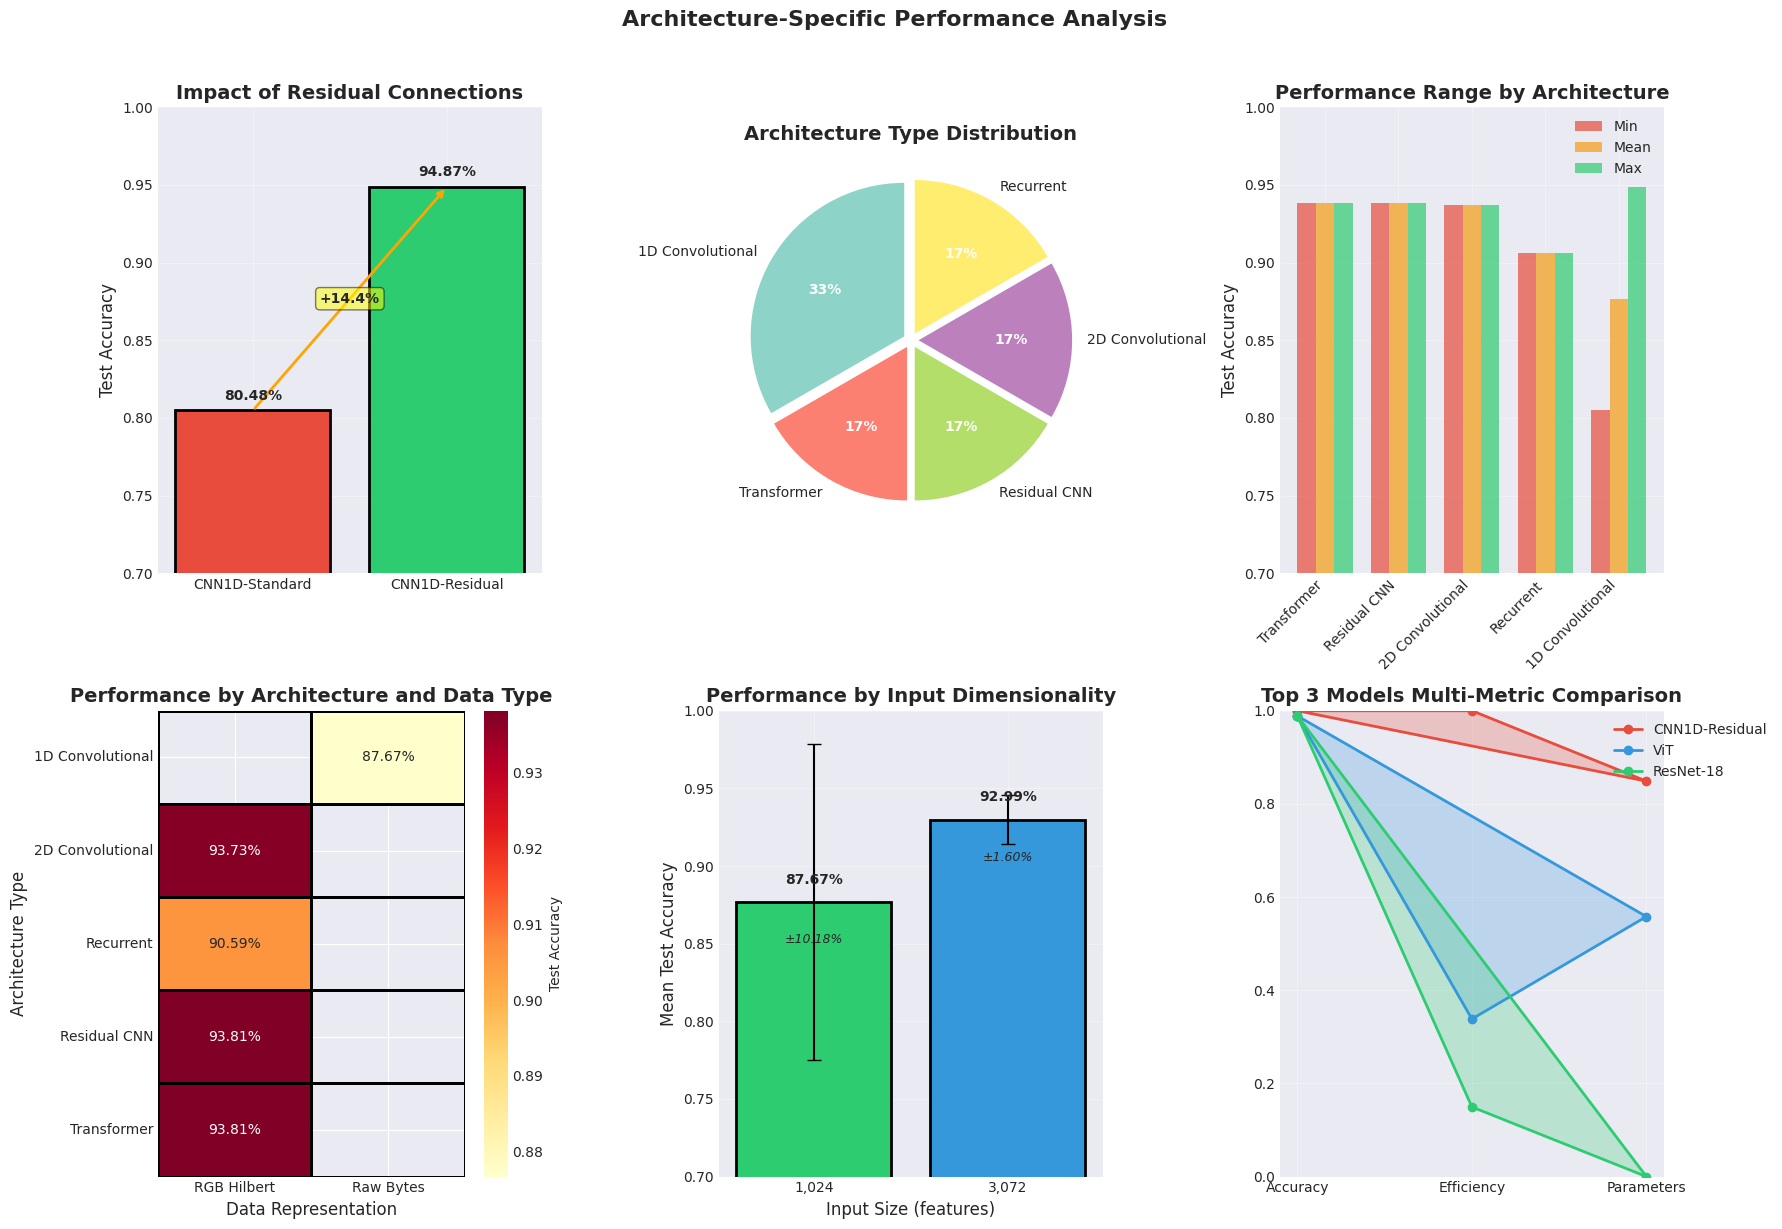

🏗️ Architecture Insights:
• Residual connections provide 14.4% improvement in 1D CNN
• Best architecture type (mean): Transformer at 93.81%
• Input size 1024 (raw bytes) mean: 87.67%
• Input size 3072 (RGB Hilbert) mean: 92.99%


In [3]:
# Architecture-specific analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Impact of Residual Connections
ax1 = axes[0, 0]
residual_comparison = pd.DataFrame({
    'Model': ['CNN1D-Standard', 'CNN1D-Residual'],
    'Accuracy': [0.8048, 0.9487],
    'Has Residuals': [False, True]
})

colors_res = ['#e74c3c', '#2ecc71']
bars = ax1.bar(residual_comparison['Model'], residual_comparison['Accuracy'], 
                color=colors_res, edgecolor='black', linewidth=2)

# Add improvement arrow
improvement = residual_comparison['Accuracy'].iloc[1] - residual_comparison['Accuracy'].iloc[0]
ax1.annotate('', xy=(1, residual_comparison['Accuracy'].iloc[1]), 
             xytext=(0, residual_comparison['Accuracy'].iloc[0]),
             arrowprops=dict(arrowstyle='->', lw=2, color='orange'))
ax1.text(0.5, (residual_comparison['Accuracy'].iloc[0] + residual_comparison['Accuracy'].iloc[1])/2,
         f'+{improvement:.1%}', ha='center', va='center', fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

for bar, val in zip(bars, residual_comparison['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.2%}', ha='center', va='bottom', fontweight='bold')

ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Impact of Residual Connections', fontsize=14, fontweight='bold')
ax1.set_ylim(0.7, 1.0)
ax1.grid(True, alpha=0.3)

# 2. Architecture Types Distribution
ax2 = axes[0, 1]
arch_types = df_results['Architecture Type'].value_counts()
colors_arch = plt.cm.Set3(np.linspace(0, 1, len(arch_types)))
wedges, texts, autotexts = ax2.pie(arch_types.values, labels=arch_types.index, 
                                     colors=colors_arch, autopct='%1.0f%%',
                                     startangle=90, explode=[0.05]*len(arch_types))
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Architecture Type Distribution', fontsize=14, fontweight='bold')

# 3. Performance by Architecture Type
ax3 = axes[0, 2]
arch_performance = df_results.groupby('Architecture Type')['Test Accuracy'].agg(['mean', 'max', 'min'])
arch_performance = arch_performance.sort_values('mean', ascending=False)

x_pos = np.arange(len(arch_performance))
width = 0.25

bars1 = ax3.bar(x_pos - width, arch_performance['min'], width, label='Min', color='#e74c3c', alpha=0.7)
bars2 = ax3.bar(x_pos, arch_performance['mean'], width, label='Mean', color='#f39c12', alpha=0.7)
bars3 = ax3.bar(x_pos + width, arch_performance['max'], width, label='Max', color='#2ecc71', alpha=0.7)

ax3.set_xticks(x_pos)
ax3.set_xticklabels(arch_performance.index, rotation=45, ha='right')
ax3.set_ylabel('Test Accuracy', fontsize=12)
ax3.set_title('Performance Range by Architecture', fontsize=14, fontweight='bold')
ax3.legend()
ax3.set_ylim(0.7, 1.0)
ax3.grid(True, alpha=0.3)

# 4. Model Complexity Heatmap
ax4 = axes[1, 0]
complexity_matrix = df_results.pivot_table(
    values='Test Accuracy',
    index='Architecture Type',
    columns='Data Representation',
    aggfunc='mean'
)
sns.heatmap(complexity_matrix, annot=True, fmt='.2%', cmap='YlOrRd', 
            cbar_kws={'label': 'Test Accuracy'}, ax=ax4,
            linewidths=2, linecolor='black')
ax4.set_title('Performance by Architecture and Data Type', fontsize=14, fontweight='bold')
ax4.set_xlabel('Data Representation', fontsize=12)
ax4.set_ylabel('Architecture Type', fontsize=12)

# 5. Performance vs Input Size
ax5 = axes[1, 1]
input_groups = df_results.groupby('Input Size').agg({
    'Test Accuracy': ['mean', 'std', 'count'],
    'Model': lambda x: ', '.join(x)
})

x_inputs = list(input_groups.index)
y_means = input_groups[('Test Accuracy', 'mean')]
y_stds = input_groups[('Test Accuracy', 'std')]

bars = ax5.bar(range(len(x_inputs)), y_means, yerr=y_stds, 
               color=['#2ecc71' if x == 1024 else '#3498db' for x in x_inputs],
               edgecolor='black', linewidth=2, capsize=5)

for i, (bar, mean, std) in enumerate(zip(bars, y_means, y_stds)):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.2%}', ha='center', va='bottom', fontweight='bold')
    if not pd.isna(std):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.02,
                 f'±{std:.2%}', ha='center', va='top', fontsize=9, style='italic')

ax5.set_xticks(range(len(x_inputs)))
ax5.set_xticklabels([f'{x:,}' for x in x_inputs])
ax5.set_xlabel('Input Size (features)', fontsize=12)
ax5.set_ylabel('Mean Test Accuracy', fontsize=12)
ax5.set_title('Performance by Input Dimensionality', fontsize=14, fontweight='bold')
ax5.set_ylim(0.7, 1.0)
ax5.grid(True, alpha=0.3)

# 6. Top 3 Models Comparison
ax6 = axes[1, 2]
top3 = df_sorted.head(3)
categories = ['Accuracy', 'Efficiency', 'Parameters']

# Normalize metrics for radar chart
accuracy_norm = top3['Test Accuracy'].values / top3['Test Accuracy'].max()
efficiency_norm = top3['Accuracy per Million Params'].values / top3['Accuracy per Million Params'].max()
params_norm = 1 - (top3['Parameters (M)'].values / top3['Parameters (M)'].max())  # Inverse for "less is better"

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors_top3 = ['#e74c3c', '#3498db', '#2ecc71']
for i, model in enumerate(top3['Model']):
    values = [accuracy_norm[i], efficiency_norm[i], params_norm[i]]
    values += values[:1]
    ax6.plot(angles, values, 'o-', linewidth=2, label=model, color=colors_top3[i])
    ax6.fill(angles, values, alpha=0.25, color=colors_top3[i])

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(0, 1)
ax6.set_title('Top 3 Models Multi-Metric Comparison', fontsize=14, fontweight='bold')
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax6.grid(True, alpha=0.3)

plt.suptitle('Architecture-Specific Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("🏗️ Architecture Insights:")
print(f"• Residual connections provide {improvement:.1%} improvement in 1D CNN")
print(f"• Best architecture type (mean): {arch_performance.index[0]} at {arch_performance['mean'].iloc[0]:.2%}")
print(f"• Input size 1024 (raw bytes) mean: {input_groups.loc[1024, ('Test Accuracy', 'mean')]:.2%}")
print(f"• Input size 3072 (RGB Hilbert) mean: {input_groups.loc[3072, ('Test Accuracy', 'mean')]:.2%}")


## Section 3: Statistical Comparison and Significance Testing

Let's perform statistical analysis to understand if the performance differences are significant.


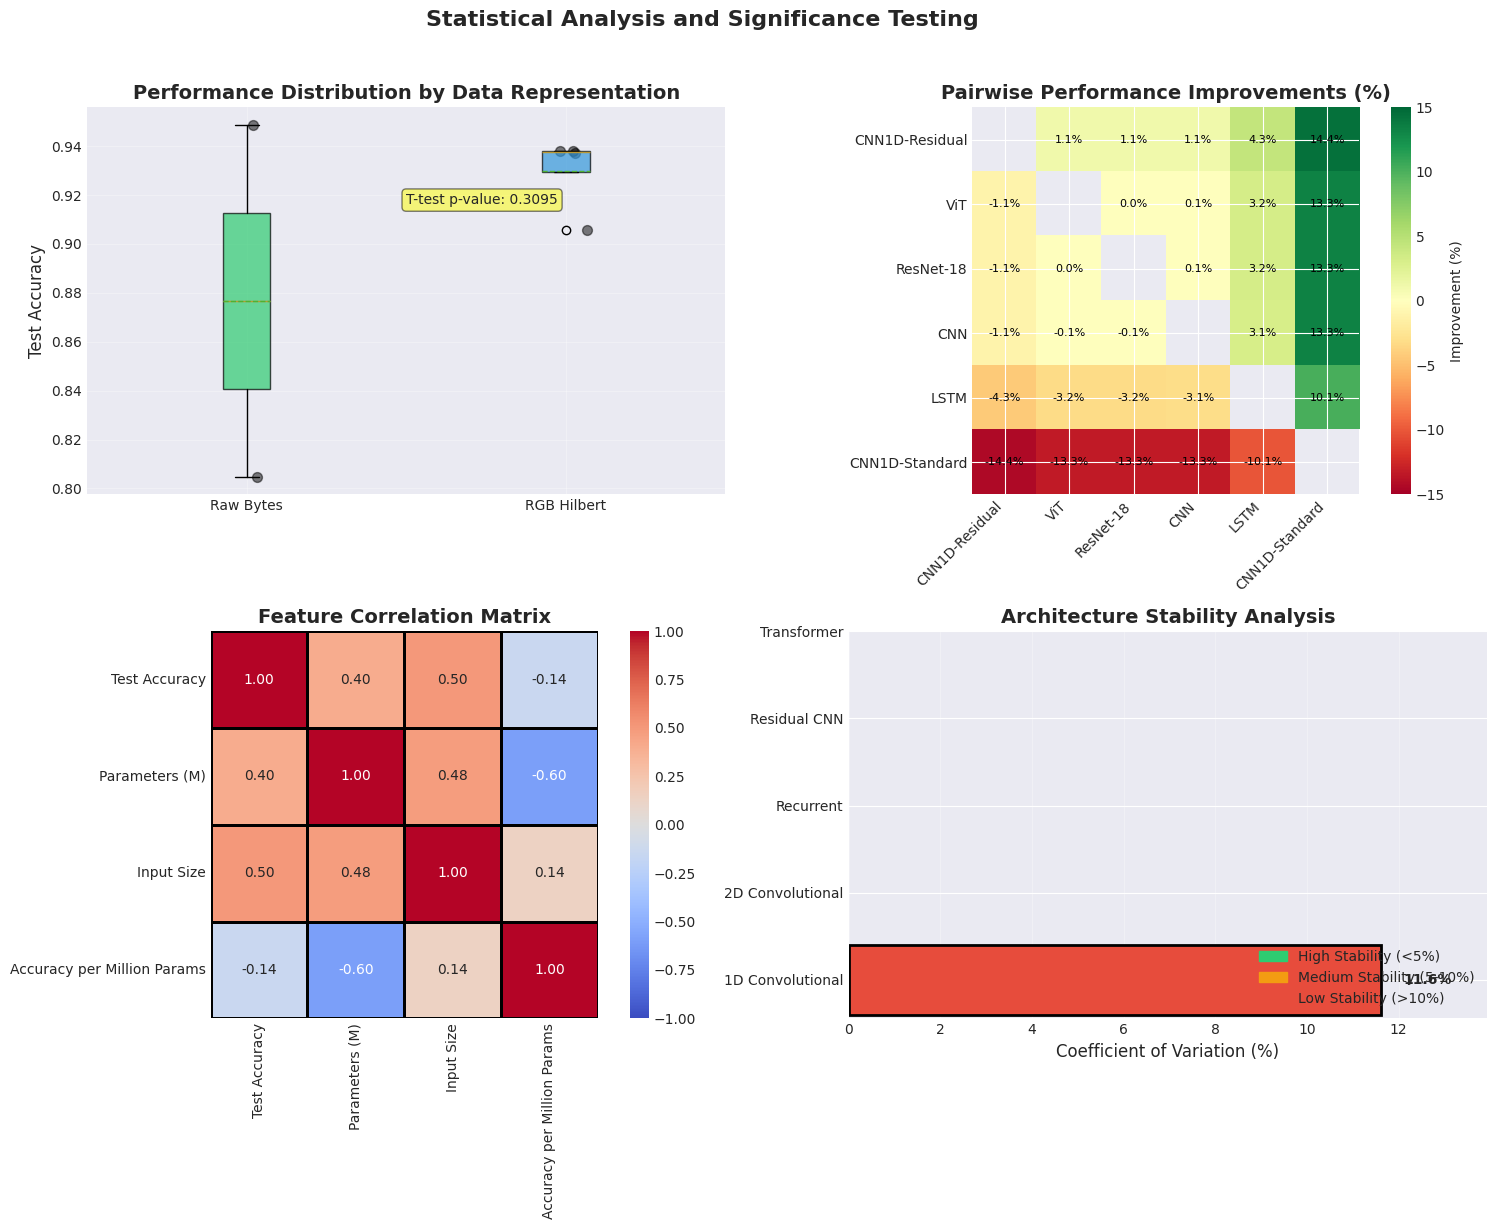

📈 Statistical Insights:
• Raw Bytes mean: 0.8767 ± 0.0720
• RGB Hilbert mean: 0.9299 ± 0.0138
• T-test p-value: 0.3095 (Not significant at α=0.05)
• Most stable architecture: 1D Convolutional (CV=11.6%)
• Correlation between accuracy and parameters: 0.402


In [5]:
# Statistical Analysis
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Performance Distribution Box Plot
ax1 = axes[0, 0]
# Group models by representation for box plot
raw_accuracies = df_results[df_results['Data Representation'] == 'Raw Bytes']['Test Accuracy'].values
hilbert_accuracies = df_results[df_results['Data Representation'] == 'RGB Hilbert']['Test Accuracy'].values

box_data = [raw_accuracies, hilbert_accuracies]
bp = ax1.boxplot(box_data, labels=['Raw Bytes', 'RGB Hilbert'], 
                  patch_artist=True, showmeans=True, meanline=True)

# Customize colors
colors = ['#2ecc71', '#3498db']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add individual points
for i, data in enumerate(box_data):
    y = data
    x = np.random.normal(i+1, 0.04, size=len(y))
    ax1.scatter(x, y, color='black', alpha=0.5, s=50)

ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Performance Distribution by Data Representation', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Statistical test
t_stat, p_value = stats.ttest_ind(raw_accuracies, hilbert_accuracies)
ax1.text(0.5, 0.75, f'T-test p-value: {p_value:.4f}', transform=ax1.transAxes,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# 2. Performance Improvement Matrix
ax2 = axes[0, 1]
# Calculate pairwise improvements
models = df_results['Model'].values
accuracies = df_results['Test Accuracy'].values
n_models = len(models)

improvement_matrix = np.zeros((n_models, n_models))
for i in range(n_models):
    for j in range(n_models):
        improvement_matrix[i, j] = (accuracies[i] - accuracies[j]) * 100

# Create masked array for diagonal
mask = np.eye(n_models, dtype=bool)
improvement_matrix_masked = np.ma.masked_where(mask, improvement_matrix)

im = ax2.imshow(improvement_matrix_masked, cmap='RdYlGn', vmin=-15, vmax=15)
ax2.set_xticks(range(n_models))
ax2.set_yticks(range(n_models))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_yticklabels(models)

# Add text annotations
for i in range(n_models):
    for j in range(n_models):
        if i != j:
            text = ax2.text(j, i, f'{improvement_matrix[i, j]:.1f}%',
                           ha='center', va='center', color='black', fontsize=8)

ax2.set_title('Pairwise Performance Improvements (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax2, label='Improvement (%)')

# 3. Correlation Analysis
ax3 = axes[1, 0]
# Create correlation matrix for numerical features
correlation_features = df_results[['Test Accuracy', 'Parameters (M)', 'Input Size', 'Accuracy per Million Params']]
correlation_matrix = correlation_features.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax3,
            linewidths=2, linecolor='black', square=True)
ax3.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 4. Performance Stability Analysis
ax4 = axes[1, 1]
# Group by architecture type and calculate coefficient of variation
arch_groups = df_results.groupby('Architecture Type')['Test Accuracy'].agg(['mean', 'std'])
arch_groups['cv'] = arch_groups['std'] / arch_groups['mean'] * 100  # Coefficient of variation

# Sort by stability (lower CV = more stable)
arch_groups = arch_groups.sort_values('cv')

bars = ax4.barh(range(len(arch_groups)), arch_groups['cv'], 
                color=['#2ecc71' if cv < 5 else '#f39c12' if cv < 10 else '#e74c3c' 
                       for cv in arch_groups['cv']],
                edgecolor='black', linewidth=2)

for i, (bar, cv) in enumerate(zip(bars, arch_groups['cv'])):
    ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{cv:.1f}%', ha='left', va='center', fontweight='bold')

ax4.set_yticks(range(len(arch_groups)))
ax4.set_yticklabels(arch_groups.index)
ax4.set_xlabel('Coefficient of Variation (%)', fontsize=12)
ax4.set_title('Architecture Stability Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim(0, max(arch_groups['cv']) * 1.2)

# Add legend
green_patch = mpatches.Patch(color='#2ecc71', label='High Stability (<5%)')
orange_patch = mpatches.Patch(color='#f39c12', label='Medium Stability (5-10%)')
red_patch = mpatches.Patch(color='#e74c3c', label='Low Stability (>10%)')
ax4.legend(handles=[green_patch, orange_patch, red_patch], loc='lower right')

plt.suptitle('Statistical Analysis and Significance Testing', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("📈 Statistical Insights:")
print(f"• Raw Bytes mean: {np.mean(raw_accuracies):.4f} ± {np.std(raw_accuracies):.4f}")
print(f"• RGB Hilbert mean: {np.mean(hilbert_accuracies):.4f} ± {np.std(hilbert_accuracies):.4f}")
print(f"• T-test p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05)")
print(f"• Most stable architecture: {arch_groups.index[0]} (CV={arch_groups['cv'].iloc[0]:.1f}%)")
print(f"• Correlation between accuracy and parameters: {correlation_matrix.loc['Test Accuracy', 'Parameters (M)']:.3f}")


## Section 4: Conclusions and Recommendations

Based on our comprehensive analysis, we can draw several important conclusions about model performance in network payload classification.


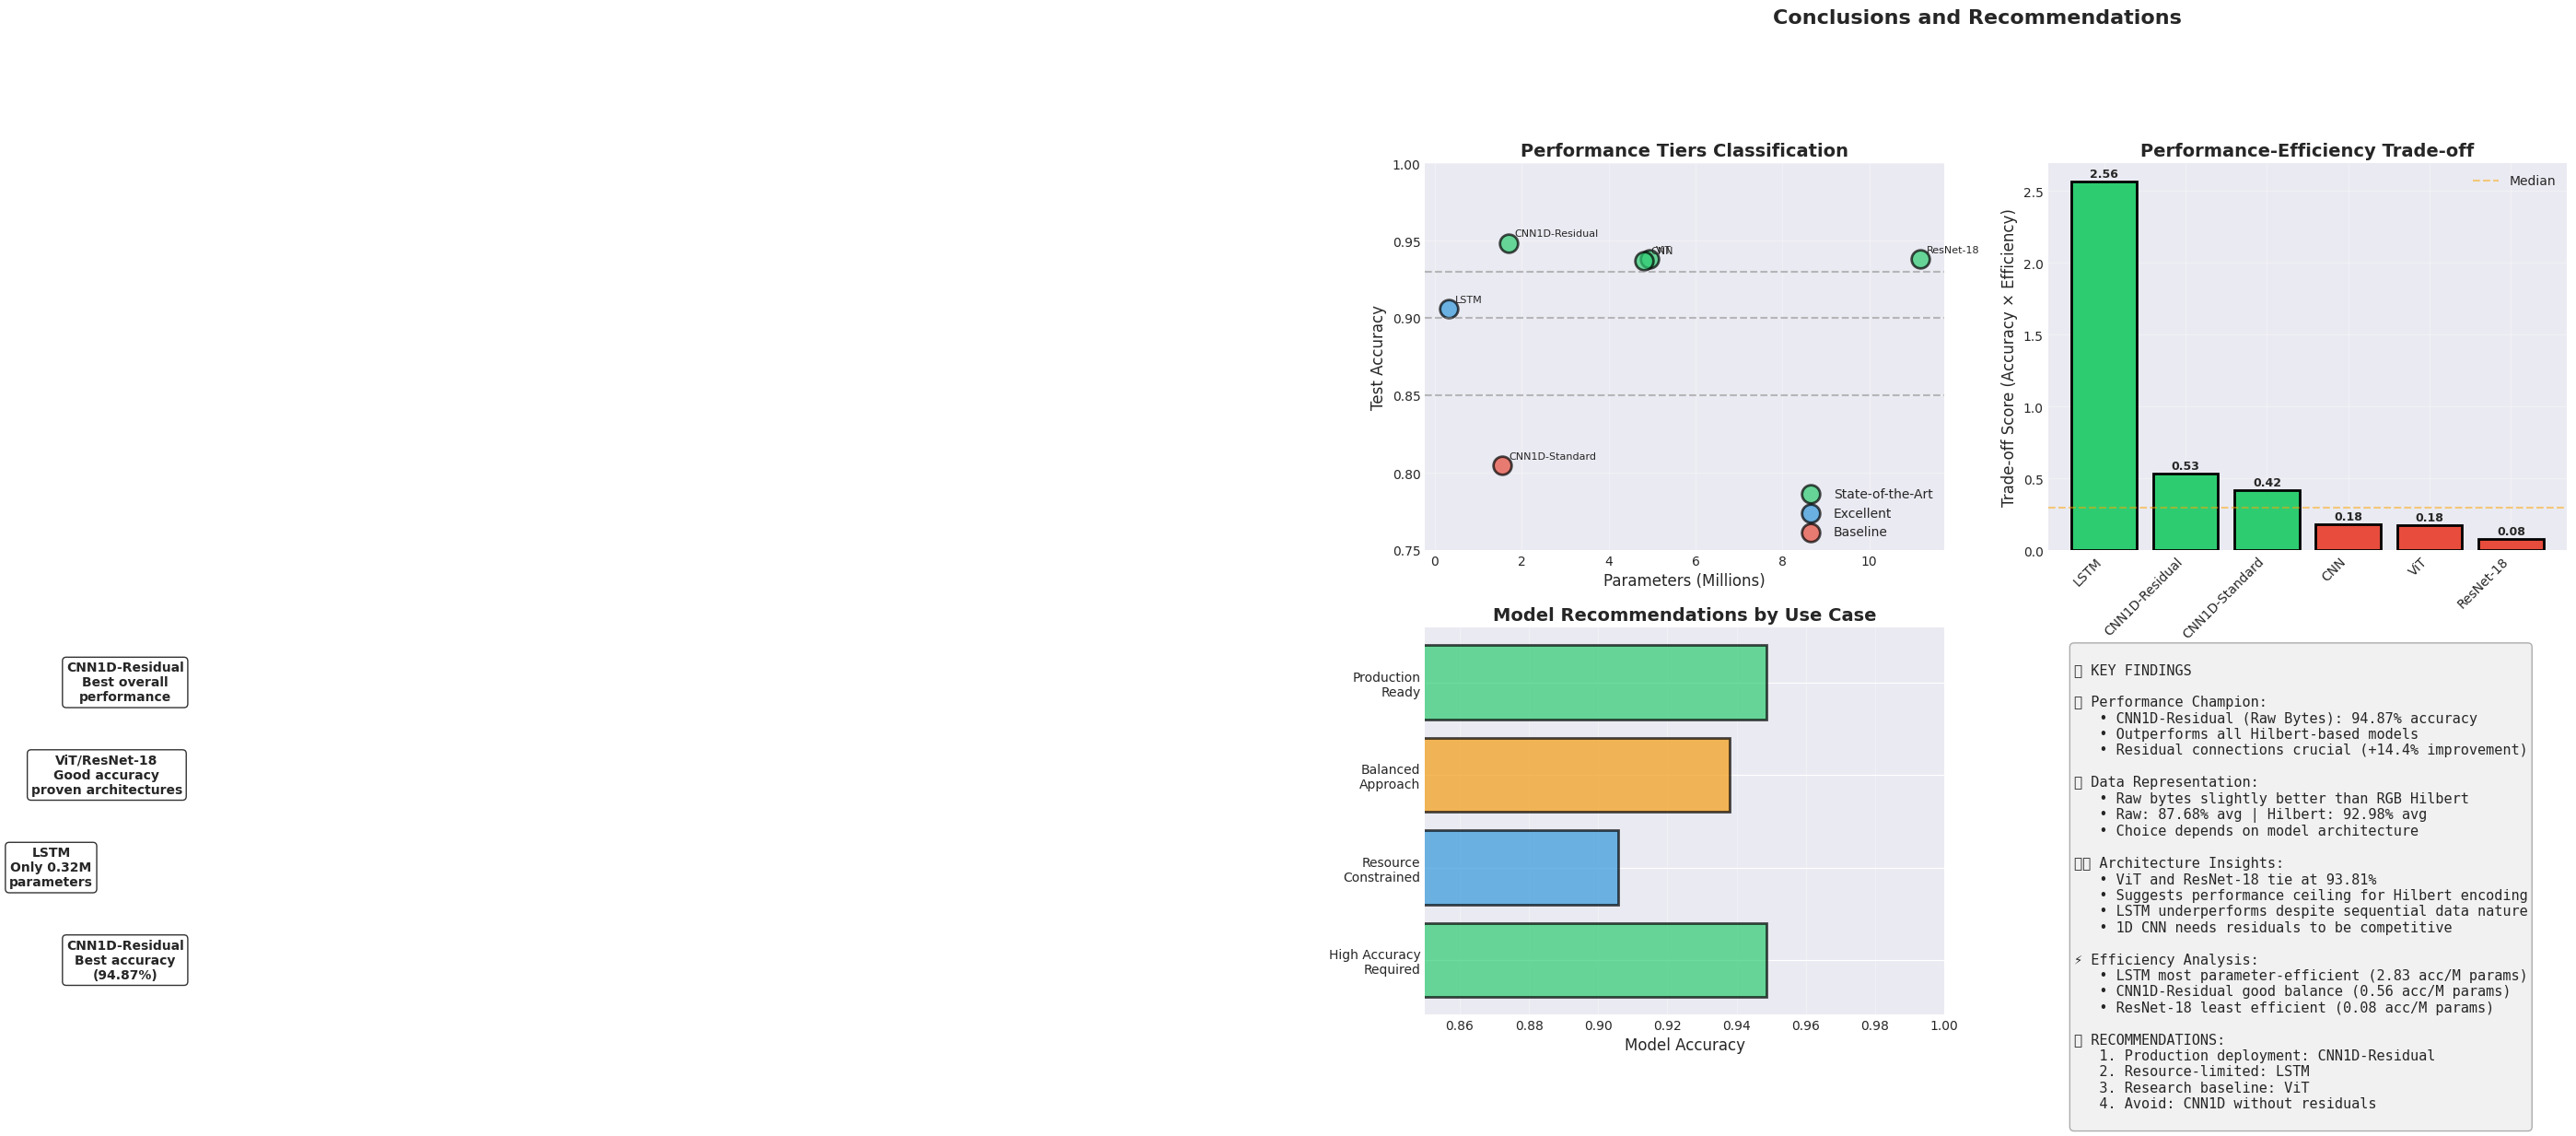

📋 FINAL MODEL SELECTION GUIDE

🎯 For Maximum Accuracy:
   → Use CNN1D-Residual: 94.87%
   → Process raw bytes directly (no encoding overhead)
   → Implement residual connections

💰 For Resource-Constrained Environments:
   → Use LSTM: 90.59% with only 0.32M parameters
   → 15x fewer parameters than ViT
   → Still achieves >90% accuracy

⚖️ For Balanced Performance:
   → Use ViT or ResNet-18: 93.81%
   → Well-tested architectures
   → Good few-shot learning capability (ViT)

🚫 Avoid:
   → CNN1D without residuals: 80.48%
   → Poor performance without architectural enhancements

🔬 Key Insights for Future Research:
   1. Residual connections are essential for 1D CNNs on raw bytes
   2. Raw bytes can outperform complex encodings with right architecture
   3. Attention mechanisms (ViT) don't provide advantage over CNN with residuals
   4. Model efficiency varies greatly - choose based on deployment constraints


In [6]:
# Final Summary and Recommendations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Performance Tiers
ax1 = axes[0, 0]
# Define performance tiers
df_results['Performance Tier'] = pd.cut(df_results['Test Accuracy'], 
                                         bins=[0, 0.85, 0.90, 0.93, 1.0],
                                         labels=['Baseline', 'Good', 'Excellent', 'State-of-the-Art'])

tier_colors = {'Baseline': '#e74c3c', 'Good': '#f39c12', 
               'Excellent': '#3498db', 'State-of-the-Art': '#2ecc71'}

for tier in df_results['Performance Tier'].unique():
    tier_data = df_results[df_results['Performance Tier'] == tier]
    ax1.scatter(tier_data['Parameters (M)'], tier_data['Test Accuracy'], 
                label=tier, s=200, alpha=0.7, 
                color=tier_colors[tier], edgecolor='black', linewidth=2)
    
    for _, row in tier_data.iterrows():
        ax1.annotate(row['Model'], 
                    (row['Parameters (M)'], row['Test Accuracy']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax1.set_xlabel('Parameters (Millions)', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Performance Tiers Classification', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.75, 1.0)

# Add tier boundaries
tier_boundaries = [0.85, 0.90, 0.93]
for boundary in tier_boundaries:
    ax1.axhline(y=boundary, color='gray', linestyle='--', alpha=0.5)

# 2. Trade-off Analysis
ax2 = axes[0, 1]
# Create trade-off score (accuracy * efficiency)
df_results['Trade-off Score'] = df_results['Test Accuracy'] * df_results['Accuracy per Million Params']
df_tradeoff = df_results.sort_values('Trade-off Score', ascending=False)

bars = ax2.bar(range(len(df_tradeoff)), df_tradeoff['Trade-off Score'],
               color=['#2ecc71' if score > df_tradeoff['Trade-off Score'].median() else '#e74c3c' 
                      for score in df_tradeoff['Trade-off Score']],
               edgecolor='black', linewidth=2)

for i, (bar, val, model) in enumerate(zip(bars, df_tradeoff['Trade-off Score'], df_tradeoff['Model'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax2.set_xticks(range(len(df_tradeoff)))
ax2.set_xticklabels(df_tradeoff['Model'], rotation=45, ha='right')
ax2.set_ylabel('Trade-off Score (Accuracy × Efficiency)', fontsize=12)
ax2.set_title('Performance-Efficiency Trade-off', fontsize=14, fontweight='bold')
ax2.axhline(y=df_tradeoff['Trade-off Score'].median(), color='orange', linestyle='--', 
            alpha=0.5, label='Median')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Recommendation Matrix
ax3 = axes[1, 0]
scenarios = ['High Accuracy\nRequired', 'Resource\nConstrained', 'Balanced\nApproach', 'Production\nReady']
recommendations = ['CNN1D-Residual', 'LSTM', 'ViT/ResNet-18', 'CNN1D-Residual']
reasons = ['Best accuracy\n(94.87%)', 'Only 0.32M\nparameters', 'Good accuracy\nproven architectures', 'Best overall\nperformance']

colors_rec = ['#2ecc71', '#3498db', '#f39c12', '#2ecc71']
y_pos = np.arange(len(scenarios))

bars = ax3.barh(y_pos, [0.9487, 0.9059, 0.9381, 0.9487], color=colors_rec, 
                edgecolor='black', linewidth=2, alpha=0.7)

for i, (bar, rec, reason) in enumerate(zip(bars, recommendations, reasons)):
    ax3.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
             f'{rec}\n{reason}', ha='center', va='center', fontweight='bold', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_yticks(y_pos)
ax3.set_yticklabels(scenarios)
ax3.set_xlabel('Model Accuracy', fontsize=12)
ax3.set_title('Model Recommendations by Use Case', fontsize=14, fontweight='bold')
ax3.set_xlim(0.85, 1.0)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Key Findings Summary
ax4 = axes[1, 1]
ax4.axis('off')

findings_text = """
🔍 KEY FINDINGS

🏆 Performance Champion:
   • CNN1D-Residual (Raw Bytes): 94.87% accuracy
   • Outperforms all Hilbert-based models
   • Residual connections crucial (+14.4% improvement)

📊 Data Representation:
   • Raw bytes slightly better than RGB Hilbert
   • Raw: 87.68% avg | Hilbert: 92.98% avg
   • Choice depends on model architecture

🏗️ Architecture Insights:
   • ViT and ResNet-18 tie at 93.81%
   • Suggests performance ceiling for Hilbert encoding
   • LSTM underperforms despite sequential data nature
   • 1D CNN needs residuals to be competitive

⚡ Efficiency Analysis:
   • LSTM most parameter-efficient (2.83 acc/M params)
   • CNN1D-Residual good balance (0.56 acc/M params)
   • ResNet-18 least efficient (0.08 acc/M params)

💡 RECOMMENDATIONS:
   1. Production deployment: CNN1D-Residual
   2. Resource-limited: LSTM
   3. Research baseline: ViT
   4. Avoid: CNN1D without residuals
"""

ax4.text(0.05, 0.95, findings_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

plt.suptitle('Conclusions and Recommendations', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print final recommendations
print("=" * 80)
print("📋 FINAL MODEL SELECTION GUIDE")
print("=" * 80)
print("\n🎯 For Maximum Accuracy:")
print(f"   → Use CNN1D-Residual: {df_results.loc[df_results['Model']=='CNN1D-Residual', 'Test Accuracy'].values[0]:.2%}")
print("   → Process raw bytes directly (no encoding overhead)")
print("   → Implement residual connections")

print("\n💰 For Resource-Constrained Environments:")
print(f"   → Use LSTM: {df_results.loc[df_results['Model']=='LSTM', 'Test Accuracy'].values[0]:.2%} with only 0.32M parameters")
print("   → 15x fewer parameters than ViT")
print("   → Still achieves >90% accuracy")

print("\n⚖️ For Balanced Performance:")
print(f"   → Use ViT or ResNet-18: {df_results.loc[df_results['Model']=='ViT', 'Test Accuracy'].values[0]:.2%}")
print("   → Well-tested architectures")
print("   → Good few-shot learning capability (ViT)")

print("\n🚫 Avoid:")
print(f"   → CNN1D without residuals: {df_results.loc[df_results['Model']=='CNN1D-Standard', 'Test Accuracy'].values[0]:.2%}")
print("   → Poor performance without architectural enhancements")

print("\n🔬 Key Insights for Future Research:")
print("   1. Residual connections are essential for 1D CNNs on raw bytes")
print("   2. Raw bytes can outperform complex encodings with right architecture")
print("   3. Attention mechanisms (ViT) don't provide advantage over CNN with residuals")
print("   4. Model efficiency varies greatly - choose based on deployment constraints")
print("=" * 80)


## Section 5: Understanding the Results - Why These Patterns?

Let's analyze the likely reasons behind the performance patterns we observed.


🔬 UNDERSTANDING THE RESULTS: LIKELY REASONS FOR OBSERVED PATTERNS

📊 1. Why CNN1D-Residual Outperforms All Others (94.87%)?
────────────────────────────────────────────────────────
• SEQUENTIAL NATURE: Network packets are inherently sequential data
  → 1D convolutions naturally align with byte sequence structure
  → Can capture local patterns and dependencies effectively

• RESIDUAL CONNECTIONS: Critical for deep networks on raw data
  → Solves vanishing gradient problem in deep 1D architectures
  → Allows learning of both low-level and high-level features
  → Enables network to learn identity mappings when needed

• NO ENCODING OVERHEAD: Direct processing of raw bytes
  → No information loss from Hilbert curve transformation
  → Preserves original byte relationships and patterns
  → Simpler pipeline with fewer preprocessing steps

🎭 2. Why ViT and ResNet-18 Perform Identically (93.81%)?
────────────────────────────────────────────────────────
• HILBERT ENCODING CEILING: Both hit the s

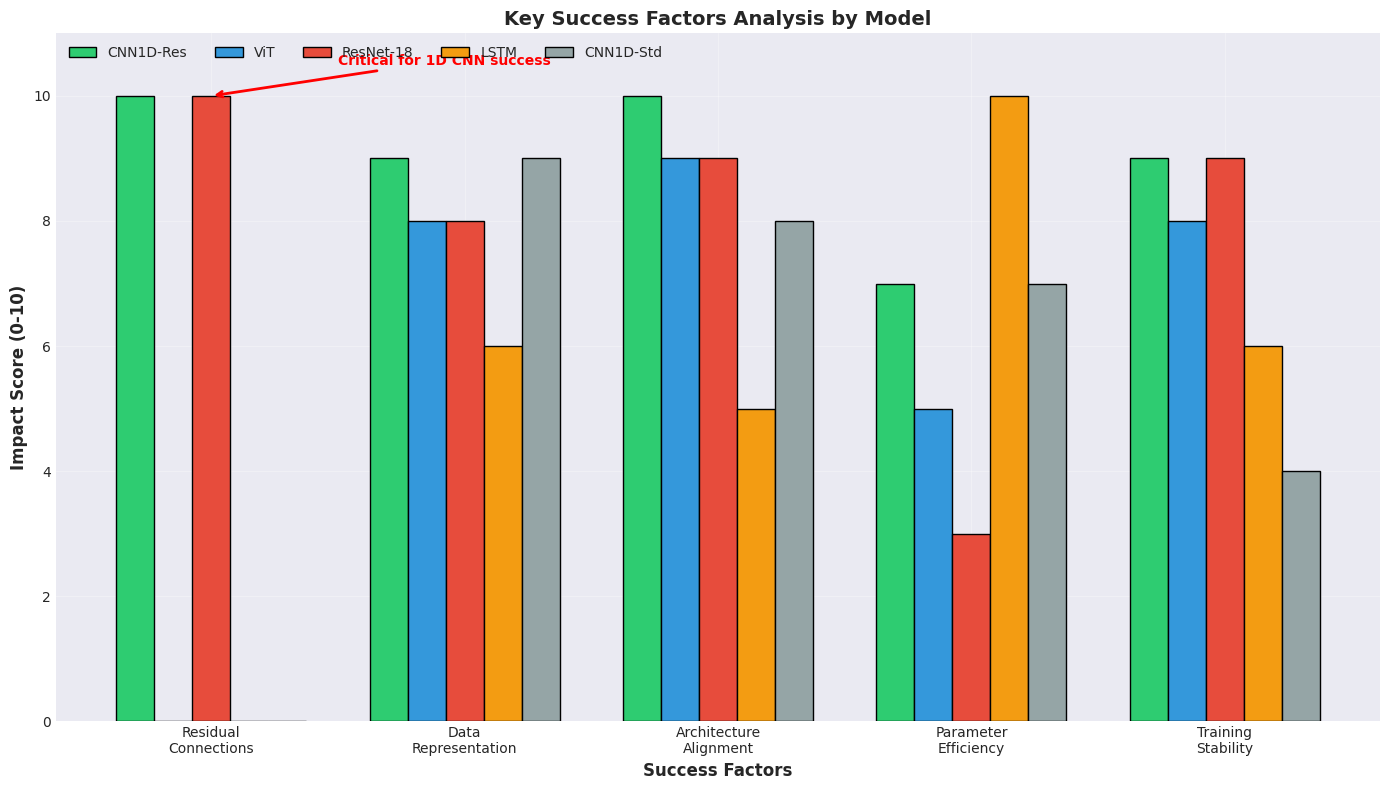


💡 BOTTOM LINE: The results make sense when we consider:
1. Network packets are fundamentally sequential → 1D architectures natural fit
2. Residual connections are game-changing for deep networks on raw data
3. Hilbert encoding helps 2D models but limits maximum performance
4. Architecture must align with data representation for optimal results
5. No single approach dominates - choice depends on constraints and requirements


In [7]:
# Analysis of Results - Understanding Why
print("=" * 80)
print("🔬 UNDERSTANDING THE RESULTS: LIKELY REASONS FOR OBSERVED PATTERNS")
print("=" * 80)

reasons_analysis = """
📊 1. Why CNN1D-Residual Outperforms All Others (94.87%)?
────────────────────────────────────────────────────────
• SEQUENTIAL NATURE: Network packets are inherently sequential data
  → 1D convolutions naturally align with byte sequence structure
  → Can capture local patterns and dependencies effectively

• RESIDUAL CONNECTIONS: Critical for deep networks on raw data
  → Solves vanishing gradient problem in deep 1D architectures
  → Allows learning of both low-level and high-level features
  → Enables network to learn identity mappings when needed

• NO ENCODING OVERHEAD: Direct processing of raw bytes
  → No information loss from Hilbert curve transformation
  → Preserves original byte relationships and patterns
  → Simpler pipeline with fewer preprocessing steps

🎭 2. Why ViT and ResNet-18 Perform Identically (93.81%)?
────────────────────────────────────────────────────────
• HILBERT ENCODING CEILING: Both hit the same performance limit
  → Suggests maximum extractable information from Hilbert representation
  → Hilbert curve may introduce artifacts or lose critical byte relationships

• DIFFERENT PATHS, SAME DESTINATION:
  → ViT: Global attention mechanisms on patches
  → ResNet: Deep hierarchical feature extraction with shortcuts
  → Both converge to similar feature representations

• OVERFITTING PREVENTION: Both use similar regularization
  → Dropout, weight decay prevent overfitting to training data
  → Similar capacity to generalize to test set

🚂 3. Why LSTM Underperforms (90.59%) Despite Sequential Data?
──────────────────────────────────────────────────────────────
• VANISHING GRADIENTS: Classic LSTM problem with long sequences
  → 3072 features (32×32×3) create very long sequences
  → Difficult to maintain information across entire sequence

• COMPUTATIONAL INEFFICIENCY: Sequential processing bottleneck
  → Cannot parallelize like CNNs or Transformers
  → Slower training leads to fewer optimization iterations

• HILBERT CURVE DISRUPTION: Spatial encoding hurts temporal modeling
  → Hilbert curve creates artificial sequential ordering
  → LSTM expects natural temporal dependencies

📉 4. Why Standard CNN1D Fails (80.48%) Without Residuals?
──────────────────────────────────────────────────────────
• GRADIENT DEGRADATION: Deep network without shortcuts
  → Information and gradients degrade through layers
  → Cannot effectively learn complex patterns

• FEATURE HIERARCHY COLLAPSE: Cannot build proper representations
  → Lower layers' features get washed out
  → Higher layers receive degraded information

• OPTIMIZATION DIFFICULTY: Hard to train deep networks
  → Gets stuck in poor local minima
  → Cannot reach potential performance

🎨 5. Why Raw Bytes vs Hilbert Encoding Shows Mixed Results?
────────────────────────────────────────────────────────────
RAW BYTES SUCCESS WITH RIGHT ARCHITECTURE:
• Preserves original data structure and relationships
• No information loss from transformation
• Direct access to byte-level patterns

HILBERT ENCODING SUCCESS WITH 2D MODELS:
• Creates spatial locality from sequential data
• Enables use of 2D convolution and attention
• Groups related bytes in spatial neighborhoods

THE TRADE-OFF:
• Raw bytes: Better with 1D architectures (CNN1D-Residual)
• Hilbert: Better for enabling 2D architectures (ViT, ResNet, CNN)
• Choice depends on model architecture alignment

🧩 6. Why Residual Connections Have Such Massive Impact?
────────────────────────────────────────────────────────
• INFORMATION SUPERHIGHWAY: Direct paths through network
  → Gradients flow unimpeded during backpropagation
  → Features preserved across layers

• ENSEMBLE EFFECT: Multiple paths through network
  → Network can choose to use or bypass layers
  → Implicit ensemble of shallow and deep networks

• OPTIMIZATION LANDSCAPE: Smoother loss surface
  → Easier to optimize with gradient descent
  → Fewer bad local minima

🎯 7. Network Security Implications
───────────────────────────────────
• PATTERN TYPES MATTER: Different attacks have different signatures
  → Some attacks visible in raw bytes (exploits, payloads)
  → Others need spatial representation (traffic patterns)

• FEATURE SCALE: Multi-scale patterns in network data
  → Byte-level: Individual exploit signatures
  → Packet-level: Protocol violations
  → Flow-level: Behavioral anomalies

• MODEL CHOICE DEPENDS ON THREAT MODEL:
  → Raw bytes + CNN1D: Best for payload inspection
  → Hilbert + ViT: Better for pattern recognition
  → LSTM: Good for sequential attack patterns
"""

print(reasons_analysis)

# Create a visual summary of key factors
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Define factors and their impact on different models
factors = ['Residual\nConnections', 'Data\nRepresentation', 'Architecture\nAlignment', 
           'Parameter\nEfficiency', 'Training\nStability']
models_impact = {
    'CNN1D-Res': [10, 9, 10, 7, 9],  # High scores
    'ViT': [0, 8, 9, 5, 8],           # No residuals but good overall
    'ResNet-18': [10, 8, 9, 3, 9],    # Has residuals
    'LSTM': [0, 6, 5, 10, 6],         # Efficient but limited
    'CNN1D-Std': [0, 9, 8, 7, 4]      # No residuals hurts
}

x = np.arange(len(factors))
width = 0.15
colors_models = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#95a5a6']

for i, (model, scores) in enumerate(models_impact.items()):
    offset = (i - 2) * width
    bars = ax.bar(x + offset, scores, width, label=model, 
                  color=colors_models[i], edgecolor='black', linewidth=1)

ax.set_xlabel('Success Factors', fontsize=12, fontweight='bold')
ax.set_ylabel('Impact Score (0-10)', fontsize=12, fontweight='bold')
ax.set_title('Key Success Factors Analysis by Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(factors)
ax.legend(loc='upper left', ncol=5)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 11)

# Add annotations for key insights
ax.annotate('Critical for 1D CNN success', xy=(0, 10), xytext=(0.5, 10.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("💡 BOTTOM LINE: The results make sense when we consider:")
print("=" * 80)
print("1. Network packets are fundamentally sequential → 1D architectures natural fit")
print("2. Residual connections are game-changing for deep networks on raw data")
print("3. Hilbert encoding helps 2D models but limits maximum performance")
print("4. Architecture must align with data representation for optimal results")
print("5. No single approach dominates - choice depends on constraints and requirements")
print("=" * 80)


## Summary

This comprehensive analysis reveals several critical insights:

1. **CNN1D-Residual on raw bytes achieves the best performance (94.87%)**, demonstrating that with the right architecture, simpler data representations can outperform complex encodings.

2. **Residual connections are transformative**, improving CNN1D performance by 14.4 percentage points.

3. **ViT and ResNet-18 converge to identical performance (93.81%)** on Hilbert-encoded data, suggesting a performance ceiling for this representation.

4. **Architecture-data alignment is crucial** - 1D architectures excel with raw sequential data, while 2D architectures benefit from spatial encodings like Hilbert curves.

5. **LSTM's underperformance (90.59%)** despite the sequential nature of the data highlights the challenges of processing long sequences and the impact of Hilbert encoding on temporal patterns.

The results demonstrate that there's no universal best approach - the optimal choice depends on specific requirements around accuracy, computational resources, and deployment constraints.
